<a href="https://colab.research.google.com/github/seidikun/trabalho_final_progamacao/blob/master/EEGNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nome: Seidi Yoamine Yamauti
email: seidi.yamauti@edu.isd.org.br

# Sumário

O objetivo desde notebook é testar o modelo EEGNet para classificação de dados EEG de imagética motora e comparação com modelos já consolidados como o xDAWN + RG e CSP + LDA, por meio da acurácia de classificação

Os dados de treino e teste foram obtidos através da plataforma EEGBCI e estão disponíveis em https://physionet.org/content/eegmmidb/1.0.0/

O modelo EEGNet é descrito no artigo [1] e possui o seguinte repositório: https://github.com/vlawhern/arl-eegmodels

Outros modelos são descritos na literatura e possuem diversas implementações. Me baseei nos códigos exemplos disponíveis em: https://mne.tools/stable/index.html

# Instalação de módulos python

In [32]:
# adicionando &> /dev/null para ocultar a saída da célula
!pip install mne &> /dev/null
!pip install sklearn &> /dev/null
!pip install matplotlib &> /dev/null
!pip install tensorflow &> /dev/null
!pip install pyriemann &> /dev/null

# Imports iniciais

In [33]:
import numpy as np

# Importação do mne
from mne import io
from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP

# Importações para EEGNet, modelo importado mais abaixo
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
K.set_image_data_format('channels_first')

# Importação PyRiemann
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.utils.viz import plot_confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

# Importação para treino e validação do modelo
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

# Plotagem de matrizes de confusão
from matplotlib import pyplot as plt

_path_images = '/content/gdrive/My Drive/EEGNet/'

Para importar o modelo EEGNet, salvei os códigos do repositório GitHub no meu Google Drive e importo a partir de lá

In [34]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [35]:
# Importa EEGNet
import sys
sys.path.append('/content/gdrive/My Drive/arl-eegmodels')
from EEGModels import EEGNet

# Código principal: inicialização dos dados e do modelo

O código foi baseado e adaptado do exemplo em https://github.com/vlawhern/arl-eegmodels e dados descritos em https://mne.tools/dev/generated/mne.datasets.eegbci.load_data.html e https://physionet.org/content/eegmmidb/1.0.0/


In [36]:
tmin, tmax = -1., 4. # tempo de janela da época
event_id   = dict(left_hand=2, right_hand=3)
subject    = 93
runs       = [4, 8, 12]  # imagética motora: mão esquerda vs mão direita

# Leitura dos dados
raw_fnames = eegbci.load_data(subject, runs) 
raw        = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
eegbci.standardize(raw)  # nomes dos canais
montage    = make_standard_montage('standard_1005')
raw.set_montage(montage)

# Retira '.' do nome dos canais
raw.rename_channels(lambda x: x.strip('.'))

# Aplica filtro passa-bandas (7Hz-30Hz)
raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge')

events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3))

picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                   exclude='bads')

# Lê as épocas (treino realizado apenas entre tmin e tmax)
epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                baseline=None, preload=True)
epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
labels = epochs.events[:, -1]


Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S093/S093R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S093/S093R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S093/S093R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passb

Os dados disponíveis para cada sujeito são poucos, apenas 45 épocas por bloco de experimento. Abaixo usei 40 para treino e 5 para testes, sem validação.


In [37]:
kernels, chans, samples = 1, 64, 801

X = epochs.get_data()*1000 # format is in (trials, channels, samples)
y = labels

X_train = X[0:40,] # 40 janelas
Y_train = y[0:40]
X_test  = X[40:,]  # 5 janelas
Y_test  = y[40:]

# convert labels to one-hot encodings.
Y_train = np_utils.to_categorical(Y_train-2, num_classes = 2)
Y_test  = np_utils.to_categorical(Y_test-2, num_classes = 2)

# COnverter para formato NCHW (trials, kernels, channels, samples) 
X_train = X_train.reshape(X_train.shape[0], kernels, chans, samples)
X_test  = X_test.reshape(X_test.shape[0], kernels, chans, samples)
   
print('Formato de X_train: ', X_train.shape)
print(X_train.shape[0], 'janelas de treino')
print(X_test.shape[0], ' janelas de teste')

unique, counts = np.unique(y, return_counts=True)
print(dict(zip(unique, counts)))

Formato de X_train:  (40, 1, 64, 801)
40 janelas de treino
5  janelas de teste
{2: 23, 3: 22}


# Modelo 1 - EEGNet-8,2

In [38]:
# Inicializa modelo EEGNet-8,2, conforme o artigo
model = EEGNet(nb_classes = 2, Chans = chans, Samples = samples, 
               dropoutRate = 0.6, kernLength = 32, F1 = 8, D = 2, F2 = 16, 
               dropoutType = 'Dropout')

# Compila modelo e configura algoritmo otimizador como adam
model.compile(loss='categorical_crossentropy', optimizer='adam',  metrics = ['accuracy'])

# Inicializa uma pasta para salvar o modelo
checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint.h5', verbose=1,
                               save_best_only=True)

In [39]:
# Mostra o modelo, camada a camada
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 64, 801)]      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 64, 801)        256       
_________________________________________________________________
batch_normalization_3 (Batch (None, 8, 64, 801)        32        
_________________________________________________________________
depthwise_conv2d_1 (Depthwis (None, 16, 1, 801)        1024      
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 1, 801)        64        
_________________________________________________________________
activation_2 (Activation)    (None, 16, 1, 801)        0         
_________________________________________________________________
average_pooling2d_2 (Average (None, 16, 1, 200)       

In [40]:
# Treinando o modelo EEGNet-8,2
fittedModel = model.fit(X_train, Y_train, batch_size = 16, epochs = 1000, 
                        verbose = 1, callbacks=[checkpointer])


Epoch 1/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.7425 - accuracy: 0.4750
Epoch 2/1000
3/3 [==============================] - 0s 13ms/step - loss: 0.6757 - accuracy: 0.6000
Epoch 3/1000
3/3 [==============================] - 0s 13ms/step - loss: 0.6645 - accuracy: 0.6000
Epoch 4/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.6547 - accuracy: 0.6750
Epoch 5/1000
3/3 [==============================] - 0s 13ms/step - loss: 0.6833 - accuracy: 0.5500
Epoch 6/1000
3/3 [==============================] - 0s 12ms/step - loss: 0.6891 - accuracy: 0.5500
Epoch 7/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.6645 - accuracy: 0.6000
Epoch 8/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.6703 - accuracy: 0.5250
Epoch 9/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.6883 - accuracy: 0.5250
Epoch 10/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.6622 - accuracy: 0.6750
Epoch 11/1

In [41]:
probs       = model.predict(X_test)
preds       = probs.argmax(axis = -1)  
acc         = np.mean(preds == Y_test.argmax(axis=-1))
print("Classification accuracy: %f " % (acc))

Classification accuracy: 1.000000 


# Modelo 2 - xDAWN

In [42]:
# Mudando o formato dos dados para (trials, channels, samples)
X_train2      = X_train.reshape(X_train.shape[0], chans, samples)
X_test2       = X_test.reshape(X_test.shape[0], chans, samples)

In [43]:
# code is taken from PyRiemann's ERP sample script, which is decoding in 
# the tangent space with a logistic regression
for n_components in range(8,1,-2):
  print(n_components)
  # set up sklearn pipeline
  clf = make_pipeline(XdawnCovariances(n_components),
                      TangentSpace(metric='riemann'),
                      LogisticRegression())

  preds_rg     = np.zeros(len(Y_test))

  # train a classifier with xDAWN spatial filtering + Riemannian Geometry (RG)
  # labels need to be back in single-column format
  clf.fit(X_train2, Y_train.argmax(axis = -1))
  preds_rg     = clf.predict(X_test2)
  
  # Calcula acurácia sobre os dados de teste
  acc2         = np.mean(preds_rg == Y_test.argmax(axis = -1))
  print("Acurácia de classificação: %f " % (acc2))

  if(acc2 > 0.8):
    print('Número de componentes com acurácia > 80%: ', n_components)


8
Acurácia de classificação: 0.400000 
6
Acurácia de classificação: 0.200000 
4
Acurácia de classificação: 0.400000 
2
Acurácia de classificação: 1.000000 
Número de componentes com acurácia > 80%:  2


# Modelo 3 - CSP + LDA
No momento de cálculo de CSP, a plotagem mostra os canais que tiveram maior importância na separação dos dados em cada classe. 
Selecionei este sujeito porque é visível como os canais selecionados são neurofisiologicamente verossímeis - estão sobre a região cortical motora das mãos esquerda e direita

Código adaptado de https://mne.tools/dev/auto_examples/decoding/plot_decoding_csp_eeg.html#sphx-glr-auto-examples-decoding-plot-decoding-csp-eeg-py

Computing rank from data with rank=None
    Using tolerance 0.11 (2.2e-16 eps * 64 dim * 7.5e+12  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.1 (2.2e-16 eps * 64 dim * 7.1e+12  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00011 (2.2e-16 eps * 64 dim * 7.9e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00011 (2.2e-16 eps * 64 dim * 7.7e+09  max singular value)
    Est

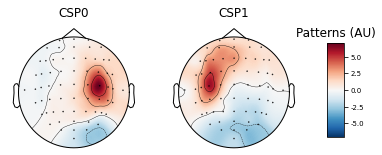

In [44]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

# Inicializa dados e cria dados de validação
scores = []
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)

# Inicializa CSP e LDA
csp = CSP(n_components=2, reg=None, log=True, norm_trace=False)
lda = LinearDiscriminantAnalysis()

# Usa a função pipeline do scikit learn
clf = Pipeline([('CSP', csp), ('LDA', lda)])

clf.fit(X_train2, Y_train.argmax(axis = -1))
preds_lda     = clf.predict(X_test2)

# Plota o CSP em topoplot
csp.fit_transform(epochs_data, labels)
fig_csp = csp.plot_patterns(epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)
fig_csp.savefig(_path_images + 'csp_subject_' + str(subject) + '.pdf') # descomentar para salvar no drive

In [45]:
# Calcula acurácia sobre os dados de teste
acc_lda         = np.mean(preds_lda == Y_test.argmax(axis = -1))
print("Acurácia de classificação: %f " % (acc_lda))

Acurácia de classificação: 1.000000 


# Matrizes de confusão de cada modelo após treino

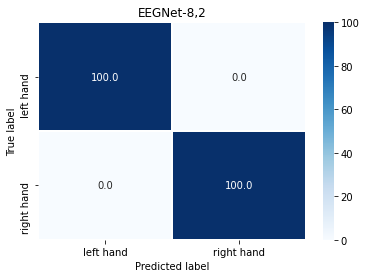

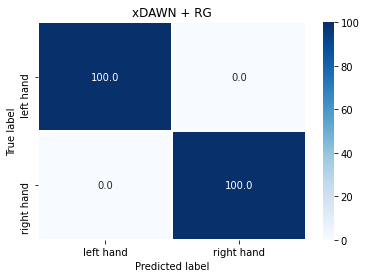

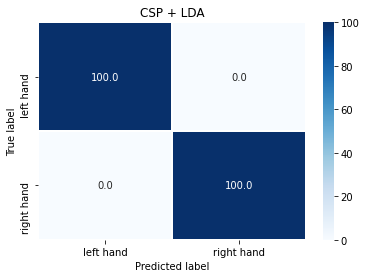

In [46]:
names        = ['left hand', 'right hand']
fig_cm1 = plt.figure(0)
plot_confusion_matrix(preds, Y_test.argmax(axis = -1), names, title = 'EEGNet-8,2')
fig_cm1.savefig(_path_images + 'confusion_matrix_subject' + str(subject) + 'EEGNet.png') 

fig_cm2 = plt.figure(1)
plot_confusion_matrix(preds_rg, Y_test.argmax(axis = -1), names, title = 'xDAWN + RG')
fig_cm2.savefig(_path_images + 'confusion_matrix_subject' + str(subject) + 'xDAWN.png') 

fig_cm3 = plt.figure(2)
plot_confusion_matrix(preds_lda, Y_test.argmax(axis = -1), names, title = 'CSP + LDA')
fig_cm3.savefig(_path_images + 'confusion_matrix_subject' + str(subject) + 'LDA.png') 


# Discussão

O modelo demonstrado EEGNet não alcançou o mesmo nível de acurácia que os modelos mais consolidados xDAWN + RG e CSP + LDA. Isso pode ser devido à não otimização dos parâmetros do modelo, mas principalmente à quantidade pequena de dados disponíveis

Uma investigação mais profunda do modelo se faz necessária

Porém, em termos de acurácia, o modelo obteve 80% nos dados de teste